### Задача
- Разработать **генетический алгоритм** для решения задачи коммивояжера (симметричный вариант)
- Использовать представление задачи в виде модели на графе
- Реализовать основные операторы генетического алгоритма: селекцию, скрещивание, мутацию
- Визуализировать процесс поиска и результаты оптимизации

### Генетический алгоритм для TSP
Генетический алгоритм - это метаэвристический алгоритм оптимизации, основанный на принципах естественного отбора. Для задачи коммивояжера:
- **Особи** представляют возможные маршруты
- **Хромосомы** кодируют порядок посещения городов
- **Скрещивание** создает новые маршруты из лучших решений
- **Мутация** вносит случайные изменения для поддержания разнообразия

---

## Импорт необходимых библиотек

In [1]:
import math
import random
import matplotlib.pyplot as plt

## Представление узлов графа

### Класс Node
Представляет узел (город) в задаче коммивояжера с координатами (x, y) и возможностью связи с другими узлами.

In [2]:
class Node():
    def __init__(self, positionX, positionY):
        self.positionX = positionX
        self.positionY = positionY
        self.next_node = None
    
    def get_pos(self):
        return (self.positionX, self.positionY)
                
    def set_next(self, next_node):
        self.next_node = next_node
    
    def get_next(self):
        return self.next_node
    
    def get_distance_to(self, other_node):
        return math.sqrt((self.positionX - other_node.positionX)**2 + (self.positionY - other_node.positionY)**2)

## Генерация узлов графа

Функция `generate_nodes` создает множество узлов с равномерным распределением:
- **Гексагональная упаковка** для оптимального размещения
- **Случайный выбор** из возможных позиций
- **Избежание перекрытий** узлов

In [3]:
def generate_nodes(height, width, nodes_num, radius) -> list:
    nodes = list()
    
    d = 2 * radius
    y_step = math.sqrt(3) * radius
    
    possible_positions = []
    
    row = 0
    y = radius
    while y + radius <= height:
        if row % 2 == 0:
            x = radius
            while x + radius <= width:
                possible_positions.append((x, y))
                x += d
        else:
            x = 2 * radius
            while x + radius <= width:
                possible_positions.append((x, y))
                x += d
        y += y_step
        row += 1

    if len(possible_positions) < nodes_num:
        raise ValueError("Cannot fit the required number of circles in the given area with the specified radius.")

    chosen_positions = random.sample(possible_positions, nodes_num)
    
    for pos in chosen_positions:
        nodes.append(Node(pos[0], pos[1]))
                
    return nodes

## Визуализация графа и маршрутов

Функция `draw_nodes` отображает:
- **Узлы** как точки с номерами
- **Соединения** как стрелки между узлами (потому что ноды имеют только next_node)
- **Маршрут** коммивояжера в виде последовательности переходов

In [4]:
def draw_nodes(nodes: list, title="Nodes visualization"):
    x = [node.get_pos()[0] for node in nodes]
    y = [node.get_pos()[1] for node in nodes]
    
    plt.figure(figsize=(10, 8))
    plt.scatter(x, y, s=100, c='red', zorder=3)
    
    for i, (xi, yi) in enumerate(zip(x, y)):
        plt.annotate(str(i), (xi, yi), xytext=(5, 5), textcoords='offset points', fontsize=8)
    
    for i, node in enumerate(nodes):
        if node.get_next() is not None:
            next_node = node.get_next()
            start_pos = node.get_pos()
            end_pos = next_node.get_pos()
            
            plt.arrow(start_pos[0], start_pos[1], 
                     end_pos[0] - start_pos[0], 
                     end_pos[1] - start_pos[1],
                     head_width=3, head_length=5, 
                     fc='blue', ec='blue', 
                     length_includes_head=True, 
                     alpha=0.7, zorder=2)
    
    plt.grid(True, alpha=0.3)
    plt.title(title)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.axis('equal')
    plt.show()

## Вспомогательные функции для работы с маршрутами

Функции для преобразования представлений маршрутов и вычисления расстояний:

In [5]:
def drop_nexts(nodes: list):
    for node in nodes:
        node.set_next(None)

In [6]:
def route_to_path(route: list, nodes: list):
    drop_nexts(nodes)
    for i in range(len(route)):
        current_node_idx = route[i]
        next_node_idx = route[(i + 1) % len(route)]
        nodes[current_node_idx].set_next(nodes[next_node_idx])

In [7]:
def calculate_route_distance(route: list, nodes: list) -> float:
    total_distance = 0
    for i in range(len(route)):
        current_node_idx = route[i]
        next_node_idx = route[(i + 1) % len(route)]
        total_distance += nodes[current_node_idx].get_distance_to(nodes[next_node_idx])
    return total_distance

## Инициализация популяции и функция приспособленности

### Генерация начальной популяции
Создание случайных маршрутов как отправная точка для генетического алгоритма.

### Функция приспособленности (fitness)
Оценка качества маршрута - обратно пропорциональна общей длине пути.

In [8]:
def generate_initial_population(population_size: int, num_nodes: int) -> list:
    population = []
    for _ in range(population_size):
        route = list(range(num_nodes))
        random.shuffle(route)
        population.append(route)
    return population

In [9]:
def calculate_fitness(route: list, nodes: list) -> float:
    distance = calculate_route_distance(route, nodes)
    return 1.0 / (1.0 + distance)

In [10]:
def evaluate_population(population: list, nodes: list) -> list:
    fitness_scores = []
    for route in population:
        fitness = calculate_fitness(route, nodes)
        fitness_scores.append(fitness)
    return fitness_scores

## Операторы селекции

### Турнирная селекция
Выбор лучшей особи из случайной подгруппы популяции. Обеспечивает баланс между давлением отбора и разнообразием.

In [11]:
def tournament_selection(population: list, fitness_scores: list, tournament_size: int = 3) -> list:
    tournament_indices = random.sample(range(len(population)), tournament_size)
    tournament_fitness = [fitness_scores[i] for i in tournament_indices]
    winner_index = tournament_indices[tournament_fitness.index(max(tournament_fitness))]
    return population[winner_index].copy()

In [12]:
def select_parents(population: list, fitness_scores: list, num_parents: int) -> list:
    parents = []
    for _ in range(num_parents):
        parent = tournament_selection(population, fitness_scores)
        parents.append(parent)
    return parents

## Операторы скрещивания

### Order Crossover (OX)
Специализированный оператор скрещивания для задач перестановок. Сохраняет относительный порядок элементов от одного родителя и заполняет пропуски элементами от другого родителя.

In [13]:
def order_crossover(parent1: list, parent2: list) -> tuple:
    size = len(parent1)
    start, end = sorted(random.sample(range(size), 2))
    
    child1 = [-1] * size
    child2 = [-1] * size
    
    child1[start:end] = parent1[start:end]
    child2[start:end] = parent2[start:end]
    
    def fill_child(child, other_parent):
        remaining = [item for item in other_parent if item not in child]
        j = 0
        for i in range(size):
            if child[i] == -1:
                child[i] = remaining[j]
                j += 1
        return child
    
    child1 = fill_child(child1, parent2)
    child2 = fill_child(child2, parent1)
    
    return child1, child2

## Операторы мутации

### Swap Mutation
Случайная перестановка двух элементов в маршруте.

### Inversion Mutation
Обращение порядка элементов в случайно выбранном сегменте маршрута.

In [14]:
def swap_mutation(route: list, mutation_rate: float = 0.01) -> list:
    mutated_route = route.copy()
    if random.random() < mutation_rate:
        i, j = random.sample(range(len(route)), 2)
        mutated_route[i], mutated_route[j] = mutated_route[j], mutated_route[i]
    return mutated_route

In [15]:
def inversion_mutation(route: list, mutation_rate: float = 0.01) -> list:
    mutated_route = route.copy()
    if random.random() < mutation_rate:
        start, end = sorted(random.sample(range(len(route)), 2))
        mutated_route[start:end+1] = reversed(mutated_route[start:end+1])
    return mutated_route

## Основной генетический алгоритм

### Функция genetic_algorithm_tsp

Реализует полный цикл генетического алгоритма для решения TSP:

#### Основные этапы:
1. **Инициализация** начальной популяции
2. **Оценка приспособленности** всех особей
3. **Селекция** родителей для размножения
4. **Скрещивание** с заданной вероятностью
5. **Мутация** потомков
6. **Cохранение** лучших решений
7. **Замещение** старой популяции новой

#### Параметры:
- `population_size` - размер популяции
- `generations` - число поколений
- `crossover_rate` - вероятность скрещивания
- `mutation_rate` - вероятность мутации
- `elite_size` - количество элитных особей

In [ ]:
def genetic_algorithm_tsp(nodes: list, population_size: int = 100, generations: int = 500, 
                         crossover_rate: float = 0.8, mutation_rate: float = 0.02, 
                         elite_size: int = 20, verbose: bool = True) -> tuple:
    num_nodes = len(nodes)
    
    population = generate_initial_population(population_size, num_nodes)
    best_distances = []
    
    for generation in range(generations):
        fitness_scores = evaluate_population(population, nodes)
        distances = [calculate_route_distance(route, nodes) for route in population]
        
        best_idx = fitness_scores.index(max(fitness_scores))
        best_distance = distances[best_idx]
        best_distances.append(best_distance)
        
        if verbose and generation % 50 == 0:
            print(f"Поколение {generation}: Лучшее расстояние = {best_distance:.2f}")
        
        elite_indices = sorted(range(len(fitness_scores)), 
                             key=lambda i: fitness_scores[i], reverse=True)[:elite_size]
        new_population = [population[i].copy() for i in elite_indices]
        
        while len(new_population) < population_size:
            parent1 = tournament_selection(population, fitness_scores)
            parent2 = tournament_selection(population, fitness_scores)
            
            if random.random() < crossover_rate:
                child1, child2 = order_crossover(parent1, parent2)
            else:
                child1, child2 = parent1.copy(), parent2.copy()
            
            child1 = inversion_mutation(child1, mutation_rate)
            child2 = inversion_mutation(child2, mutation_rate)
            
            new_population.extend([child1, child2])
        
        population = new_population[:population_size]
    
    fitness_scores = evaluate_population(population, nodes)
    best_idx = fitness_scores.index(max(fitness_scores))
    best_route = population[best_idx]
    
    if verbose:
        final_distance = calculate_route_distance(best_route, nodes)
        print(f"Финальное поколение: Лучшее расстояние = {final_distance:.2f}")
    
    return best_route, best_distances

## Визуализация прогресса эволюции

Функция для отображения графика сходимости алгоритма - изменения лучшего решения по поколениям.

In [17]:
def plot_evolution_progress(best_distances: list):
    plt.figure(figsize=(10, 6))
    plt.plot(best_distances, 'b-', linewidth=2)
    plt.title('Эволюция лучшего решения', fontsize=14)
    plt.xlabel('Поколение', fontsize=12)
    plt.ylabel('Длина маршрута', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.show()

## Демонстрация работы алгоритма

Функция `run_tsp_example` демонстрирует полный цикл решения задачи коммивояжера:

#### Этапы демонстрации:
1. **Генерация узлов** графа в заданной области
2. **Отображение** исходного распределения городов
3. **Запуск генетического алгоритма** с настроенными параметрами
4. **Визуализация лучшего найденного маршрута**
5. **Отображение графика сходимости** алгоритма

#### Результаты:
- Найденный маршрут с минимальной длиной
- Динамика улучшения решения по поколениям
- Сравнение качества решения

In [18]:
def run_tsp_example():
    height, width = 500, 500
    nodes_num = 50
    radius = 10
    
    print("Генерация узлов...")
    nodes = generate_nodes(height, width, nodes_num, radius)
    
    print("Исходные узлы:")
    draw_nodes(nodes, "Исходные узлы")
    
    print("Запуск генетического алгоритма...")
    best_route, best_distances = genetic_algorithm_tsp(
        nodes, 
        population_size=100, 
        generations=2000, 
        crossover_rate=0.8, 
        mutation_rate=0.02,
        elite_size=10,
        verbose=True
    )
    
    route_to_path(best_route, nodes)
    
    final_distance = calculate_route_distance(best_route, nodes)
    print(f"\nЛучший найденный маршрут: {best_route}")
    print(f"Длина маршрута: {final_distance:.2f}")
    
    draw_nodes(nodes, f"Лучший маршрут (длина: {final_distance:.2f})")
    
    plot_evolution_progress(best_distances)

Генерация узлов...
Исходные узлы:


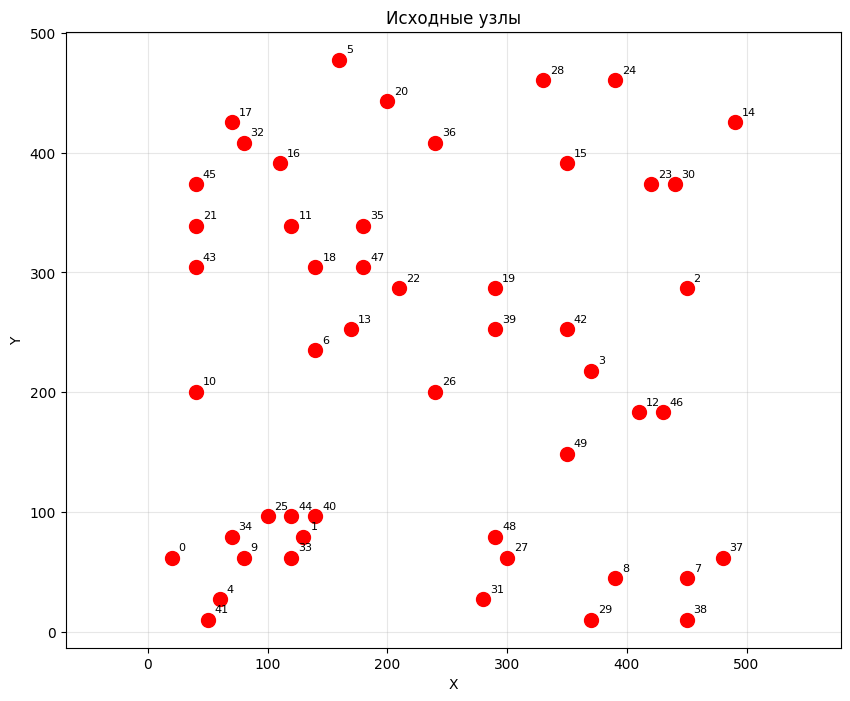

Запуск генетического алгоритма...
Поколение 0: Лучшее расстояние = 11668.12
Поколение 50: Лучшее расстояние = 5799.35
Поколение 50: Лучшее расстояние = 5799.35
Поколение 100: Лучшее расстояние = 5050.32
Поколение 100: Лучшее расстояние = 5050.32
Поколение 150: Лучшее расстояние = 4572.39
Поколение 150: Лучшее расстояние = 4572.39
Поколение 200: Лучшее расстояние = 4231.70
Поколение 200: Лучшее расстояние = 4231.70
Поколение 250: Лучшее расстояние = 3925.67
Поколение 250: Лучшее расстояние = 3925.67
Поколение 300: Лучшее расстояние = 3774.18
Поколение 300: Лучшее расстояние = 3774.18
Поколение 350: Лучшее расстояние = 3706.07
Поколение 350: Лучшее расстояние = 3706.07
Поколение 400: Лучшее расстояние = 3437.97
Поколение 400: Лучшее расстояние = 3437.97
Поколение 450: Лучшее расстояние = 3419.70
Поколение 450: Лучшее расстояние = 3419.70
Поколение 500: Лучшее расстояние = 3398.07
Поколение 500: Лучшее расстояние = 3398.07
Поколение 550: Лучшее расстояние = 3398.07
Поколение 550: Лучшее р

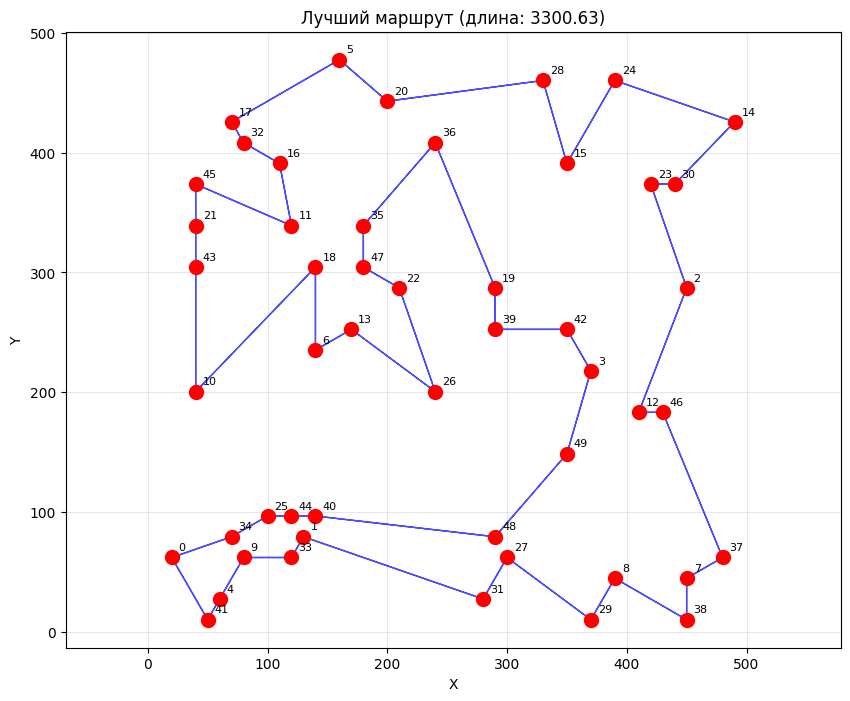

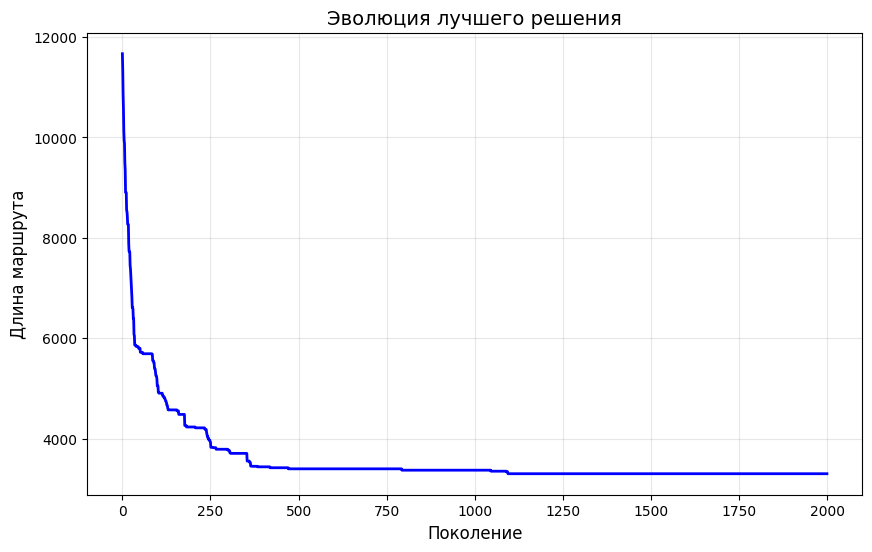

In [19]:
run_tsp_example()